<a href="https://colab.research.google.com/github/Enkhamgalan1230/ML-projects/blob/main/spamDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

import string
import nltk
#A lot of the data that you could be analyzing is unstructured data and contains human-readable text.
#Before you can analyze that data programmatically, you first need to preprocess it
from nltk.corpus import stopwords
# Stop words are like 'the, a, an, etc'
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
#Tokenizer from TensorFlow provides a convenient way to preprocess text data for
#machine learning tasks by converting text into numerical representations that can be fed into neural networks or other machine learning models.
from tensorflow.keras.preprocessing.text import Tokenizer
#Preparing sequence data for machine learning tasks, ensuring uniformity in sequence lengths across the dataset.
from tensorflow.keras.preprocessing.sequence import pad_sequences
#function for splitting a dataset into training and testing subsets
from sklearn.model_selection import train_test_split

#EarlyStopping is a callback that helps prevent overfitting by stopping the training process when the model's performance on a validation dataset begins to degrade.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#telling Python to suppress any warning messages that may occur during the execution of your script.
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Padding and truncating are techniques used to adjust the length of sequences to make them uniform when dealing with variable-length data, such as text sequences in natural language processing. These techniques are commonly used in machine learning and deep learning tasks where input data needs to be of consistent size.

Padding:

Padding involves adding extra tokens or values to the sequences to make them all the same length.
It is typically done by appending special tokens (e.g., zeros) to the beginning or end of shorter sequences until they reach a predefined length.
Padding ensures that all sequences in the dataset have the same length, which is often required for processing in neural networks and other machine learning algorithms.
Padding is crucial for tasks like text classification or sentiment analysis, where inputs must have consistent dimensions.

Truncating:

Truncating involves removing tokens or values from sequences that exceed a specified maximum length.
It is performed to ensure that all sequences in the dataset are within a predefined length limit.
Truncation can occur at the beginning or end of the sequence, depending on the application and requirements.
Truncating is often necessary when dealing with sequences longer than the desired maximum length to prevent memory overflow or computational inefficiency.

In [21]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.6.6-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.6
    Uninstalling kaggle-1.6.6:
      Successfully uninstalled kaggle-1.6.6


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [24]:
! cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/

In [25]:
! chmod 600 ~/.kaggle/kaggle.json

In [26]:
#! kaggle datasets list

In [27]:
!kaggle datasets download -d jackksoncsie/spam-email-dataset

spam-email-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
!unzip spam-email-dataset.zip

Archive:  spam-email-dataset.zip
replace emails.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [29]:
data = pd.read_csv('emails.csv',encoding='latin-1')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [30]:
data.shape

(5728, 2)

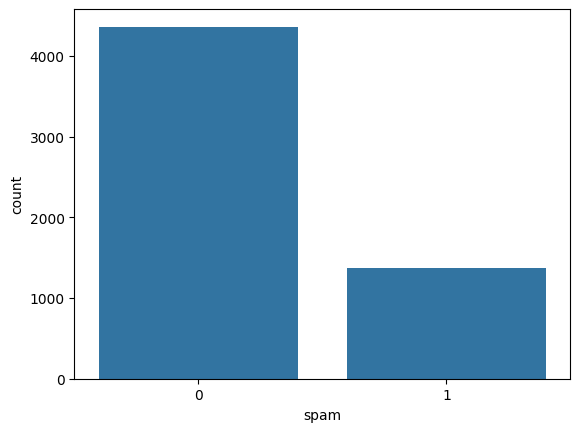

In [31]:
#ratio of spam and normal msg in dataset,
sns.countplot(x = 'spam', data=data )
plt.show()

Text(0.5, 0, 'Message types')

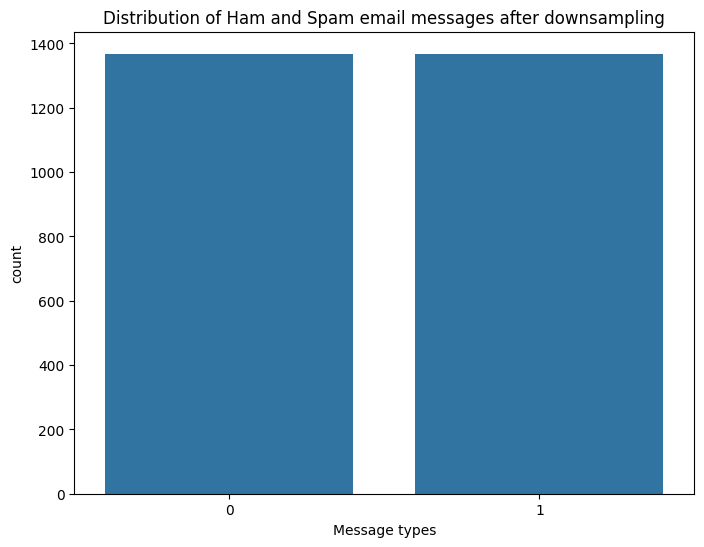

In [32]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)

# Plotting the counts of down sampled dataset

#This line appends the downsampled ham messages (ham_msg) to the original spam messages (spam_msg), creating a balanced dataset.
#reset_index(drop=True) resets the index of the combined dataset to ensure a continuous index without retaining the old indices.
balanced_data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [33]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [47]:
#This removes punctuation like !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
punctuations_list = string.punctuation

#This function takes a text parameter and removes all punctuation characters from it.
#It achieves this using str.maketrans() to create a translation table that maps each punctuation
#character to None, effectively removing them, and then using text.translate() to apply this translation to the input text.
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


In [35]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


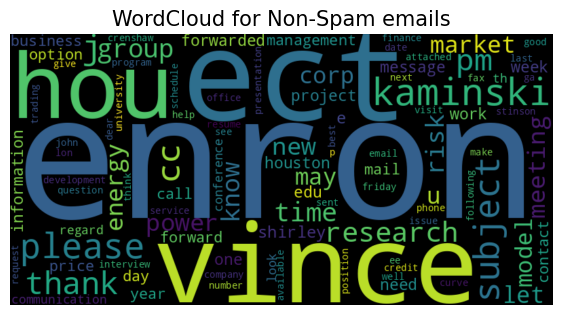

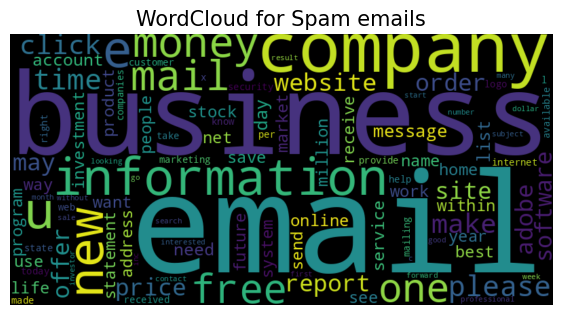

In [36]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


We cannot feed words to a machine learning model because they work on numbers only. So, first, we will convert our words to vectors with the token IDs to the corresponding words and after padding them our textual data will arrive to a stage where we can feed it to a model.

In [37]:
# It splits the data to training part and testing part and test size represents the ratio
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42) # This parameter sets the random seed for reproducibility.
                                                                       # It ensures that the split will be the same every time you run the code with the same random state.

So, each most used words gonna be saved as unique number starting from 1 and now this text is going to be converted to sequences of those token numbers, after that the longest sequence is will be max and any other smaller ones there will be extra 0 s will be added to match.

In [46]:
 # Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')
word_index = tokenizer.word_index
#print(word_index)

{'enron': 1, 'ect': 2, 'vince': 3, 'com': 4, 'please': 5, 'hou': 6, '2000': 7, 'kaminski': 8, 'subject': 9, 'would': 10, '1': 11, 'j': 12, '2': 13, 'cc': 14, 'e': 15, 'time': 16, '3': 17, 'business': 18, 'information': 19, 'email': 20, '10': 21, 'new': 22, 'pm': 23, 'company': 24, 'may': 25, '2001': 26, 'get': 27, 'mail': 28, '5': 29, 'one': 30, 'us': 31, 'research': 32, 'http': 33, 'know': 34, 'like': 35, 'thanks': 36, 'message': 37, '00': 38, 'group': 39, 'risk': 40, 'also': 41, 'make': 42, '4': 43, 'need': 44, 'free': 45, 'power': 46, 'market': 47, 'www': 48, 'energy': 49, 'money': 50, 'see': 51, 'let': 52, 'work': 53, '11': 54, '0': 55, '30': 56, '000': 57, 'corp': 58, 'list': 59, '12': 60, 'best': 61, '01': 62, 'meeting': 63, 'forward': 64, 'price': 65, 'contact': 66, 'click': 67, 'could': 68, 'management': 69, '7': 70, 'send': 71, 'want': 72, 'year': 73, 'software': 74, 'edu': 75, 'shirley': 76, 'use': 77, 'call': 78, 'order': 79, 'help': 80, 'address': 81, 'forwarded': 82, 'proj

The Sequential model, which is very straightforward (a simple list of layers), but is limited to single-input, single-output stacks of layers (as the name gives away).
The Functional API, which is an easy-to-use, fully-featured API that supports arbitrary model architectures. For most people and most use cases, this is what you should be using. This is the Keras "industry strength" model.
Model subclassing, where you implement everything from scratch on your own. Use this if you have complex, out-of-the-box research use cases.

This adds an Embedding layer to the model. The Embedding layer is used for text processing and word embeddings. It converts integer indices representing words into dense vectors of fixed size (output_dim). input_dim is the size of the vocabulary (number of unique words) plus one for out-of-vocabulary words, and input_length is the length of input sequences.


The dense layers in a neural network are also known as fully connected layers. Let's break down their functionality and how they work:

Fully Connected Layers:

Dense layers are called fully connected because each neuron in a dense layer receives input from every neuron in the previous layer (if it's not a convolutional or recurrent layer). Each neuron in a dense layer contributes to the output of the layer by performing a weighted sum of its inputs followed by an activation function.

Weighted Sum:

For each neuron in a dense layer, the inputs from the previous layer (or the input layer) are multiplied by corresponding weights. These weights represent the strength of the connections between the neurons. Then, the weighted inputs are summed up along with a bias term.

Activation Function:

After the weighted sum is calculated, an activation function is applied element-wise to the result. This activation function introduces non-linearity to the model, allowing it to learn complex patterns in the data.

Number of Neurons:

The number of neurons in a dense layer determines the dimensionality of the output space. In the provided code, the first dense layer has 32 neurons, and the second dense layer has 1 neuron. The choice of the number of neurons depends on the complexity of the problem and the size of the data.

In [39]:
 # Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
#This adds an LSTM (Long Short-Term Memory) layer with 16 units to the model.
#LSTM is a type of recurrent neural network (RNN) capable of learning long-term dependencies.
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808737 (3.09 MB)
Trainable params: 808737 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Name:

The model is named "sequential", which is the default name for a sequential model in Keras.

Layer Information:

Embedding Layer:
Type: Embedding
Output Shape: (None, 100, 32)
Parameters: 805,024
Explanation: This layer converts integer indices representing words into dense vectors of size 32. The input sequences have a length of 100 (max_len). The total number of parameters in this layer depends on the size of the vocabulary (805,024 in this case) and the embedding dimension (32).
LSTM Layer:
Type: LSTM
Output Shape: (None, 16)
Parameters: 3,136
Explanation: This layer is a Long Short-Term Memory (LSTM) layer with 16 units. It processes the input sequences and outputs a vector of size 16. The total number of parameters is determined by the number of units and the input size.
Dense Layer 1:
Type: Dense
Output Shape: (None, 32)
Parameters: 544
Explanation: This dense layer has 32 neurons with a ReLU activation function. It receives input from the LSTM layer and outputs a vector of size 32. The number of parameters depends on the number of input and output neurons.
Dense Layer 2:
Type: Dense
Output Shape: (None, 1)
Parameters: 33
Explanation: This dense layer has a single neuron with a sigmoid activation function. It receives input from the previous dense layer and outputs a scalar value between 0 and 1, representing the probability of the positive class. The number of parameters depends on the number of input and output neurons.
Total Parameters:

Total params: 808,737
Trainable params: 808,737
Non-trainable params: 0
Explanation: Total params indicate the total number of parameters in the model. Trainable params are parameters that will be updated during training. Non-trainable params are parameters that are not updated during training, such as the parameters in the embedding layer when using pre-trained embeddings.





The compile method in TensorFlow is used to configure the model for training. It takes several parameters:

loss: This parameter specifies the loss function to be optimized during training. In this case, tf.keras.losses.BinaryCrossentropy(from_logits=True) is used. BinaryCrossentropy is a common choice for binary classification problems, and from_logits=True indicates that the model's output is not normalized by a sigmoid activation function before computing the loss. This is typically used when the model's final output is linear (before applying activation) and the loss function will handle the sigmoid activation internally.

metrics: This parameter specifies the evaluation metrics to be used during training and testing. In this case, 'accuracy' is used as the metric, which calculates the accuracy of the model's predictions.

optimizer: This parameter specifies the optimization algorithm to be used during training. Here, 'adam' optimizer is used. Adam is a popular optimization algorithm known for its adaptive learning rate capabilities and efficiency in training deep neural networks.

Putting it all together, model.compile configures the model for training with the specified loss function, evaluation metric, and optimizer. With this configuration, the model is ready to be trained using the fit method on training data.

In [40]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

These lines of code set up two important callbacks in TensorFlow/Keras: EarlyStopping and ReduceLROnPlateau. Callbacks are functions that are executed during training at certain points, such as the end of an epoch or after a batch has been processed. They provide a way to perform actions like saving the model's weights, adjusting the learning rate, or stopping training early based on certain conditions.

EarlyStopping:

EarlyStopping is a callback that stops the training process if a monitored metric (in this case, validation accuracy) stops improving for a certain number of epochs (defined by the patience parameter).
patience=3 means that training will stop if the validation accuracy doesn't improve after 3 epochs.
monitor='val_accuracy' specifies that validation accuracy will be monitored for improvement.
restore_best_weights=True indicates that, upon early stopping, the model's weights will be restored to the ones that achieved the best performance on the validation set.
ReduceLROnPlateau:

ReduceLROnPlateau is a callback that reduces the learning rate when a monitored metric has stopped improving.
patience=2 means that the learning rate will be reduced if the validation loss doesn't improve after 2 epochs.
monitor='val_loss' specifies that validation loss will be monitored for improvement.
factor=0.5 indicates the factor by which the learning rate will be reduced. In this case, it will be reduced by half when triggered.
verbose=0 controls the verbosity of the output during training. Setting it to 0 means silent mode (no output).
These callbacks help in improving the efficiency and performance of the model during training by preventing overfitting (EarlyStopping) and adjusting the learning rate dynamically (ReduceLROnPlateau) based on the validation metrics. They are passed to the fit method of the model during training to enable their functionality.

In [41]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

 It's not necessary to reach the specified number of epochs if the model has already converged and is performing well on the validation dataset.

In [42]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20
69/69 [==============================] - 7s 54ms/step - loss: 0.6541 - accuracy: 0.6577 - val_loss: 0.4695 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 3s 45ms/step - loss: 0.2111 - accuracy: 0.9506 - val_loss: 0.1641 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 4s 57ms/step - loss: 0.1535 - accuracy: 0.9621 - val_loss: 0.2098 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 4s 57ms/step - loss: 0.1470 - accuracy: 0.9644 - val_loss: 0.1137 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 3s 46ms/step - loss: 0.0897 - accuracy: 0.9803 - val_loss: 0.1339 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 3s 44ms/step - loss: 0.0636 - accuracy: 0.9881 - val_loss: 0.1290 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 4s 58ms/step - loss: 0.0

In [43]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 [==============================] - 0s 10ms/step - loss: 0.0842 - accuracy: 0.9854
Test Loss : 0.08416834473609924
Test Accuracy : 0.985401451587677


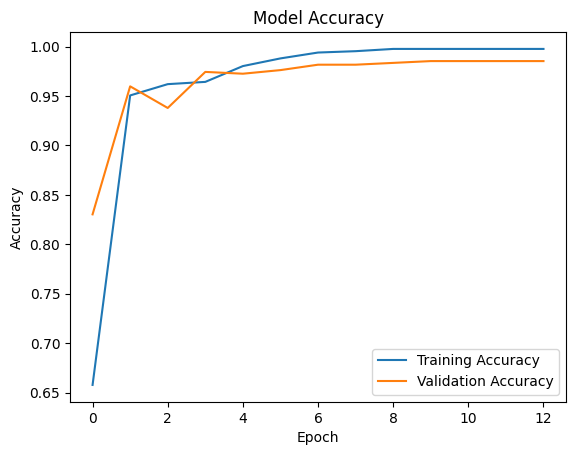

<Figure size 640x480 with 0 Axes>

In [44]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('result.png')